In [ ]:
#1. 패키지 임포트
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#2. GPU 사용체크
is_cuda = False
if torch.cuda.is_available():
  is_cuda = True
print(is_cuda)

True


In [ ]:
#3. MNIST 데이터 다운로드

#transforms.Composer([...])는 여러 변환 단계를 결합하여 실행.
transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081),)])
'''
transforms.ToTensor(): 이미지를 PyTorch 텐서로 변환. 또한, 이미지의 픽셀 값 범위를 [0,255]에서 [0.0, 1.0]으로 스케일링
transforms.Normalize: 텐서의 채널별 평균과 표준편차를 사용하여 정규화. MNIST는 흑백이라 채널 1개
평균값 0.1307, 표준편차 0.3081
'''
# transform=transformation은 위의 정의한 변환을 데이터에 적
train_dataset = datasets.MNIST('data/', train=True, transform=transformation, download=True)
test_dataset = datasets.MNIST('data/', train=False, transform=transformation, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 153269991.09it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 115257558.35it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 47562627.38it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20911667.14it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
#4. 네트워크 정의

#상속받는 것은 신경망 모듈의 기본 클래스
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    #Conv2d는 드롭아웃의 2차원 버전을 의미. 컨볼루션 레이어의 출력에 많이 적용.
    self.conv1 = nn.Conv2d(1,10, kernel_size=5) #첫번째 컨볼루션 레이어 정의. 1개의 입력채널(흑백이미지)을 받아 10개의 출력 채널로 매핑, 커널의 크기는 5x5
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)#두번째 컨볼루션 레이어 정의 10개의 입력채널을 받아 20개의 출력 채널로 매핑. 커널의 크기 5x5
    self.conv2_drop = nn.Dropout2d() #과적합 방지위해 뉴런의 일부 무작위를 넣는 드롭아웃 정의
    self.fc1 = nn.Linear(320, 50) # 완전연결레이어 320개의 입력 특성을 받아 50개 출력
    self.fc2 = nn.Linear(50, 10) # 50개의 출력을 최종적으로 10개의 클래스(숫자0-9)에 매핑

  def forward(self, x): #순전파
    x = F.relu(F.max_pool2d(self.conv1(x), 2)) #첫번째 컨볼루션 레이어를 통과한 후 최대풀링을 적용하고, Relu적용. 최대 풀링의 윈도우 크기는 2x2
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) #두번째 컨볼로션레이어 통과하고 드롭아웃을 적용하고 다시 최대풀링과 relu 적용
    x = x.view(-1, 320) #텐서를 재구성하여 완전 연결 레이어에 적합한 형태 만듬. -1은 배치 크기를 유지하며, 320은 이진 레이어에서의 출력 크기와 일치
    x = F.relu(self.fc1(x)) #첫번째 완전 연결 레이어 통과한 후, relu활성화 함수 적용
    #x = F.dropout(x, p=0.1, training=self.training)
    x = self.fc2(x) # 두번째 완전 연결 레이어 통과
    return F.log_softmax(x, dim=1) #최종 출력에 로그 소프트맥스 적용. dim=1은 연산적용 차원

In [ ]:
#5. 모델 불러오기
model = Net()
if is_cuda:
  model.cuda()

In [ ]:
#6. 최적화 함수
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
#7. 훈련 데이터 변수 준비
data, target = next(iter(train_loader))

In [ ]:
#8. 훈련 및 검증 함수
def fit(epoch, model, data_loader, phase='training', volatile=False):
  if phase == 'training': #훈련용
    model.train()
  if phase == 'validation': #validation용
    model.eval()
    volatile=True #연산을 추적하지 않음
  running_loss = 0.0
  running_correct = 0
  for batch_idx, (data, target) in enumerate(data_loader):
    if is_cuda: #cuda사용가능하면 데이터와 타겟을 gpu로 이동
      data, target = data.cuda(), target.cuda()
    data, target = Variable(data, volatile), Variable(target) #variable은 텐서 추적하는 것(연산 추적) -> 4.0이후로는 안씀
    if phase == 'training':#훈련용이면 optimizer 0으로 초기
      optimizer.zero_grad()
    output = model(data) #모델에 입력데이터를 전달하여 순전파 수행
    #Negative Log Likelihood Loss. 다중 클래스 분류문제에서 자주 사용됨
    loss = F.nll_loss(output, target) # output은 모델의 예측 로그 확률, target은 정답 레이블

    #running_loss += F.nll_loss(output, target, size_average=False).data[0]
    running_loss += F.nll_loss(output, target, reduction='sum').item() #모델출력(output)과 실제타켓(target)간의 NLLLoss 계산.reduction=sum 모든 배치 손실함수 합
    preds = output.data.max(dim=1, keepdim=True)[1] #모델 출력에서 가장 높은 값을 가진 인덱스 찾기
    running_correct += preds.eq(target.data.view_as(preds)).cpu().sum() #예측 클래스와, 실제 클래스 일치한지 확인.일치하면 true(1), 아니면 false(0)
    #훈련단계에서만 사용 -> 테스트단계에서는 평가만 하기때문에 역전파를 할 이유가 없음!!
    if phase == 'training':
      loss.backward()
      optimizer.step()
  loss = running_loss/len(data_loader.dataset)
  accuracy = 100. * running_correct/len(data_loader.dataset)

# {loss:{5}.{2}}는 전체 자리 5자리 수, 소수점 2번째 까
  print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
  return loss,accuracy

In [20]:
# 9. 훈련
train_losses, train_accuracy = [], []
val_losses, val_accuracy = [], []
for epoch in range(1, 20):
  epoch_loss, epoch_accuracy = fit(epoch, model, train_loader, phase='training')
  val_epoch_loss, val_epoch_accuracy = fit(epoch, model, test_loader, phase='validation')
  train_losses.append(epoch_loss)
  train_accuracy.append(epoch_accuracy)
  val_losses.append(val_epoch_loss)
  val_accuracy.append(val_epoch_accuracy)

training loss is 0.036 and training accuracy is 59338/60000      98.9
validation loss is 0.024 and validation accuracy is 9923/10000     99.23
training loss is 0.036 and training accuracy is 59285/60000     98.81
validation loss is 0.026 and validation accuracy is 9920/10000      99.2
training loss is 0.037 and training accuracy is 59291/60000     98.82
validation loss is 0.027 and validation accuracy is 9920/10000      99.2
training loss is 0.036 and training accuracy is 59346/60000     98.91
validation loss is 0.024 and validation accuracy is 9932/10000     99.32
training loss is 0.035 and training accuracy is 59317/60000     98.86
validation loss is 0.024 and validation accuracy is 9923/10000     99.23
training loss is 0.035 and training accuracy is 59343/60000      98.9
validation loss is 0.026 and validation accuracy is 9925/10000     99.25
training loss is 0.034 and training accuracy is 59329/60000     98.88
validation loss is 0.026 and validation accuracy is 9922/10000     99.22

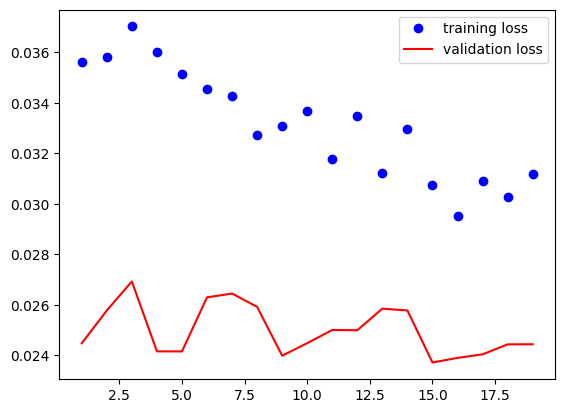

In [21]:
#10 훈련 데이터와 검증 데이터의 손실 그래프
plt.plot(range(1, len(train_losses)+1), train_losses, 'bo', label = 'training loss')
plt.plot(range(1, len(val_losses) +1), val_losses, 'r', label = 'validation loss')
plt.legend()


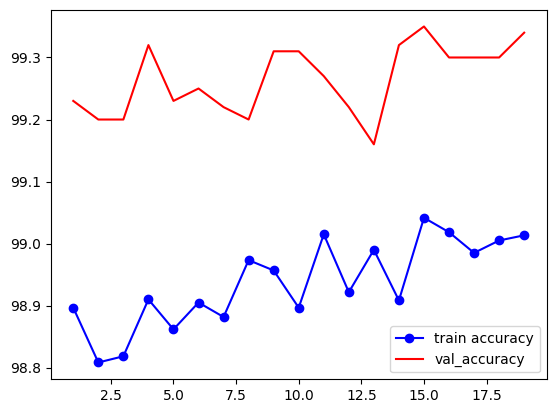

In [22]:
#11.훈련 데이터와 검증 데이터의 정확도 그래프
plt.plot(range(1, len(train_accuracy)+1), train_accuracy, 'bo-', label = 'train accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, 'r-', label = 'val_accuracy')
plt.legend()